<a href="https://colab.research.google.com/github/soobook/PyTorch-DL/blob/main/code/PT16.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 16회차: DC-GAN을 활용한 손글씨 모방하기 (2) - 모델 구현

In [ ]:
# ================================================================
# DC-GAN (PyTorch / MNIST) 전체 구현
# ================================================================

# (1) 필수 라이브러리 임포트
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.utils as vutils
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

# (2) 하이퍼파라미터 및 디바이스 설정
lr = 0.0002
batch_size = 128
image_size = 64
nz = 100           # latent vector 크기
num_epochs = 20    # GPU 사용 시 한 에폭당 1.5 ~ 2분 소요
beta1 = 0.5        # Adam optimizer의 beta1
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
# (3) 데이터셋 준비 (MNIST 로드 및 전처리)

# 이미지 크기를 64 x 64로 리사이즈하고 텐서로 변환한 뒤, 픽셀 값을 -1 ~ 1 범위로 정규화
transform = transforms.Compose([
    transforms.Resize(image_size),       # 이미지 크기를 (28→) 64x64로 확장
    transforms.ToTensor(),               # 이미지를 PyTorch 텐서로 변환 (0~1 범위)
    transforms.Normalize((0.5,), (0.5,)) # 평균 0.5, 표준편차 0.5로 정규화 → [-1, 1] 범위
])

# MNIST 데이터셋 다운로드 및 전처리 적용
dataset = datasets.MNIST(
    root='./data',          # 데이터 저장 경로
    train=True,             # 학습용 데이터만 사용
    transform=transform,    # 위에서 정의한 전처리 적용
    download=True           # 데이터 없으면 자동 다운로드
)

# 데이터셋을 배치 단위로 불러올 수 있게 DataLoader 구성
dataloader = DataLoader(
    dataset,                # 전처리된 MNIST 데이터셋
    batch_size=batch_size,  # 미리 정의한 배치 크기 사용 (예: 128)
    shuffle=True            # 에폭마다 데이터 셔플 → 학습 다양성 증가
)

100%|██████████| 9.91M/9.91M [00:00<00:00, 17.8MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 483kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.50MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 11.8MB/s]


### 생성자 마지막 층에서 활성화 함수 tanh()를 사용해 [-1, 1] 이미지를 생성하는 이유
  - 픽셀값이 너무 크거나 작지 않게 “자연스러운 이미지 범위”로 맞춰서 학습 안정성과 출력 품질을 향상
  - 생성자가 만들어 내는 가짜 이미지가 [-1, 1]의 값이므로
  - 진짜 이미지도 같은 범위인 [-1, 1]로 정규화 해줘야 판별자(Discriminator)가 올바르게 비교가 가능

### 함수 tanh()
$$
\tanh(x) = \frac{\sinh(x)}{\cosh(x)} = \frac{e^{x} - e^{-x}}{e^{x} + e^{-x}}
$$

In [ ]:
# 시각화 준비
!pip install koreanize_matplotlib
import koreanize_matplotlib
%config InlineBackend.figure_format = 'retina'

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 49.8 MB/s eta 0:00:00


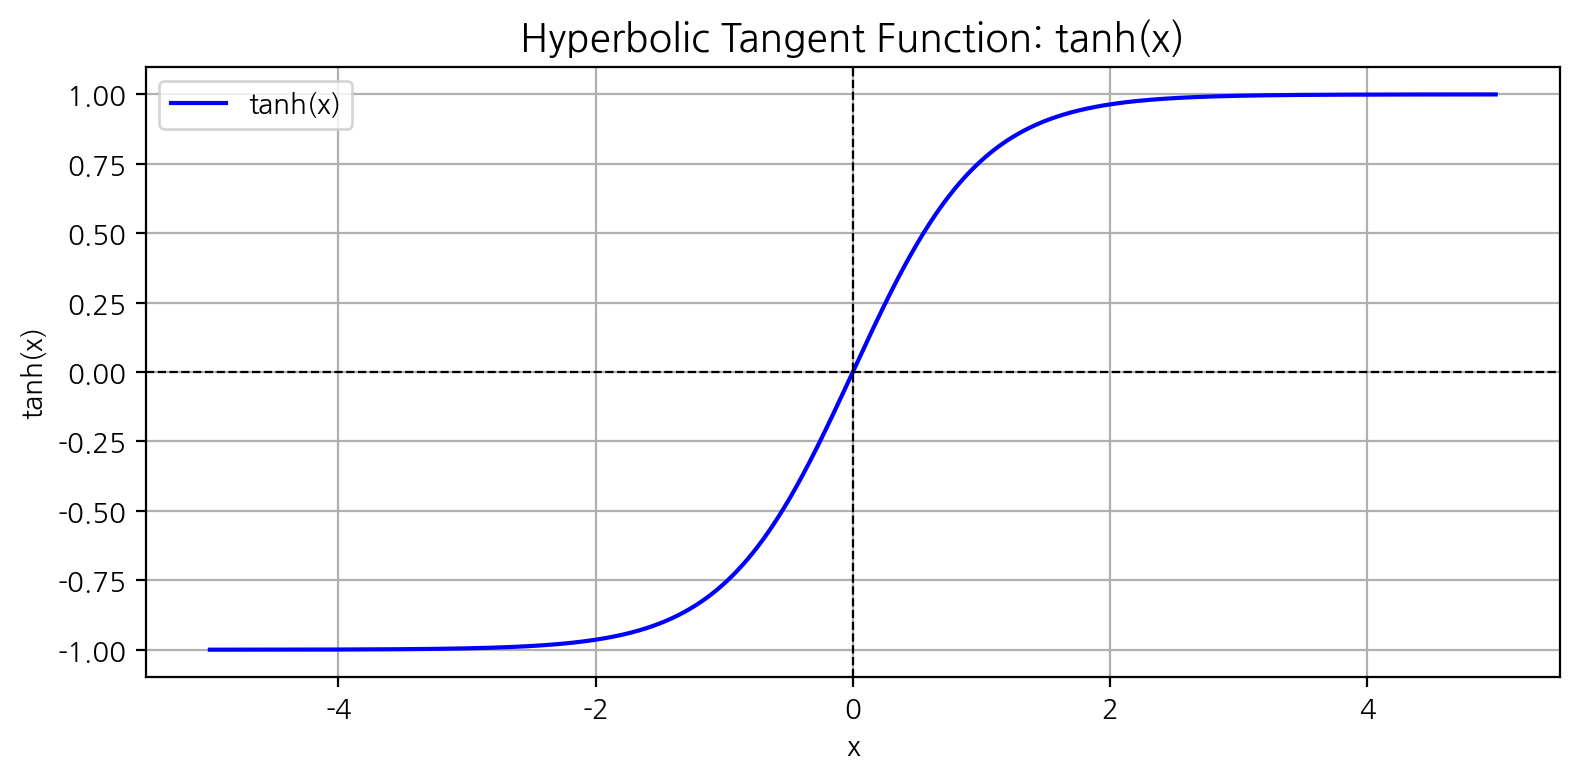

In [ ]:
import torch
import matplotlib.pyplot as plt

# 입력 범위: -5 ~ +5
x = torch.linspace(-5, 5, steps=1000)

# tanh 함수 적용
y = torch.tanh(x)

# 그래프 시각화
plt.figure(figsize=(8, 4))
plt.plot(x.numpy(), y.numpy(), label='tanh(x)', color='blue')
plt.title('Hyperbolic Tangent Function: tanh(x)', fontsize=14)
plt.xlabel('x')
plt.ylabel('tanh(x)')
plt.grid(True)
plt.axhline(0, color='black', linestyle='--', linewidth=0.8)
plt.axvline(0, color='black', linestyle='--', linewidth=0.8)
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
# (4) Discriminator 클래스 정의
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            # 입력: 1채널 64x64 (MNIST는 흑백 이미지)
            # nn.Conv2d(입력 채널 수, 출력 채널 수, 커널 크기, stride, padding, ...)
            # 출력 채널 64개, 필터로 4x4 커널, 스트라이드 2, 패딩 1 적용
            nn.Conv2d(1, 64, 4, 2, 1, bias=False), # 64x64 -> 32x32
            nn.LeakyReLU(0.2, inplace=True), # LeakyReLU는 비선형 활성화

            # 필터 수 128로 증가 (채널 점점 늘려감)
            nn.Conv2d(64, 128, 4, 2, 1, bias=False), # 32x32 -> 16x16
            # BatchNorm은 학습 안정화, 내부 공변량 감소
            nn.BatchNorm2d(128), nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(128, 256, 4, 2, 1, bias=False), # 16x16 -> 8x8
            nn.BatchNorm2d(256), nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(256, 512, 4, 2, 1, bias=False), # 8x8 -> 4x4
            nn.BatchNorm2d(512), nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(512, 1, 4, 1, 0, bias=False), # 4x4 -> 1x1
            nn.Sigmoid()
        )
    def forward(self, x):
        return self.main(x).view(-1) # 모델의 출력을 1차원 벡터로 평탄화(flatten)하여 반환

In [ ]:
# (5) Generator 클래스 정의 - latent vector를 이미지로 변환하는 업샘플러
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        # nn.Sequential로 업샘플링 계층을 순차적으로 정의
        self.main = nn.Sequential(
            # 입력: (batch_size, 100, 1, 1) → 출력: (batch_size, 512, 4, 4)
            nn.ConvTranspose2d(nz, 512, 4, 1, 0, bias=False),
            nn.BatchNorm2d(512),  # 정규화로 학습 안정화
            nn.ReLU(True),        # 비선형 활성화

            # 입력: (512, 4, 4) → 출력: (256, 8, 8)
            nn.ConvTranspose2d(512, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(True),

            # 입력: (256, 8, 8) → 출력: (128, 16, 16)
            nn.ConvTranspose2d(256, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(True),

            # 입력: (128, 16, 16) → 출력: (64, 32, 32)
            nn.ConvTranspose2d(128, 64, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(True),

            # 입력: (64, 32, 32) → 출력: (1, 64, 64) = 최종 이미지
            nn.ConvTranspose2d(64, 1, 4, 2, 1, bias=False),
            nn.Tanh()  # 픽셀 값을 [-1, 1] 범위로 정규화
        )

    # forward: z 벡터 입력 시 위 계층을 통과해 이미지 생성
    def forward(self, x):
        return self.main(x)

In [ ]:
# (6) 생성자 / 판별자 모델 객체 생성과 정보 출력
netG = Generator().to(device)
netD = Discriminator().to(device)
# (6-1) 모델 구조 출력
print("=== Generator (netG) 구조 ===")
print(netG)
print("\n=== Discriminator (netD) 구조 ===")
print(netD)

=== Generator (netG) 구조 ===
Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=Fa

### 전치 합성곱(Transposed Convolution)
- 역방향 합성곱(Deconvolution)이라고도 부름
- 특징맵(feature map)의 공간적 크기를 크게(up-sampling) 하기 위한 방법
  - 1×1 → 4×4 → 8×8 → 16×16 → 즉, 이미지를 점점 크게 키워가는 역할
- 파이토치에서는 nn.ConvTranspose2d() 사용
  - 출력 크기 계산 공식(Input: 입력 이미지(또는 특징 맵)의 가로 또는 세로 크기)

$$
\text{Output} = (\text{Input} - 1) \times \text{stride} - 2 \times \text{padding} + \text{kernel_size} + \text{output_padding}
$$



In [ ]:
import torch.nn as nn

deconv = nn.ConvTranspose2d(
    in_channels=1,    # 입력 채널 수
    out_channels=1,   # 출력 채널 수
    kernel_size=3,    # 필터 크기
    stride=2,         # 이동 간격
    padding=1,        # 패딩 크기
    output_padding=1, # 출력에 추가할 여분
    bias=False        # 편향(bias) 사용 여부
)


### 전치 합성곱 연산 stride=1 사례

- 전개된 식 (Transpose Convolution 출력 크기 공식)

$$
\text{Output} = (\text{Input} - 1) \times \text{stride} - 2 \times \text{padding} + \text{kernel_size} + \text{output_padding}
$$

- 예시 대입 (Input=2, stride=1, padding=0, kernel_size=2, output_padding=0)

$$
3 = (2 - 1) \times 1 - 2 \times 0 + 2 + 0
$$


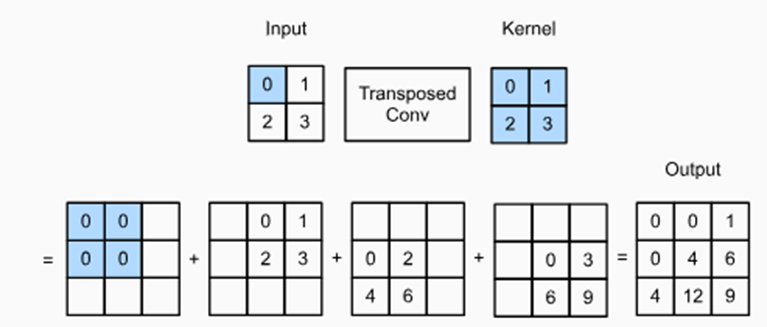

In [ ]:
import torch
import torch.nn as nn

# 입력 텐서 (1채널, 1배치, 2x2 이미지)
input_tensor = torch.tensor([[[[0., 1.],
                               [2., 3.]]]])

# 커널 정의 (1 input channel → 1 output channel, kernel size 2x2)
# weight는 ConvTranspose2d 레이어에서 학습 파라미터 형태로 존재함
deconv = nn.ConvTranspose2d(in_channels=1, out_channels=1, kernel_size=2, stride=1, padding=0, bias=False)
# Kernel인 weight 수동 설정 (커널을 그대로 복사)
with torch.no_grad():
    deconv.weight[:] = torch.tensor([[[[0., 1.],
                                       [2., 3.]]]])
# 연산 수행
output = deconv(input_tensor)
# 결과 출력
print("Output Tensor:")
print(output.squeeze())  # 보기 편하게 squeeze

Output Tensor:
tensor([[ 0.,  0.,  1.],
        [ 0.,  4.,  6.],
        [ 4., 12.,  9.]], grad_fn=<SqueezeBackward0>)


### 전치 합성곱 연산 stride=2 사례

- 전개된 식 (Transpose Convolution 출력 크기 공식)

$$
\text{Output} = (\text{Input} - 1) \times \text{stride} - 2 \times \text{padding} + \text{kernel_size} + \text{output_padding}
$$

- 예시 대입 (Input=2, stride=2, padding=0, kernel_size=2, output_padding=0)

$$
4 = (2 - 1) \times 2 - 2 \times 0 + 2 + 0
$$

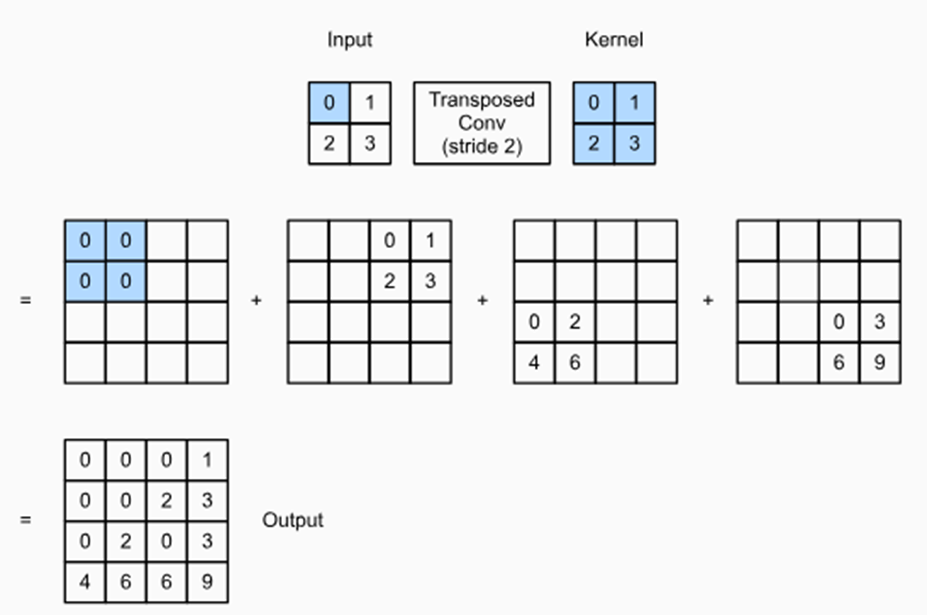

In [ ]:
import torch
import torch.nn as nn

# 입력 텐서 (배치=1, 채널=1, 높이=2, 너비=2)
input_tensor = torch.tensor([[[[0., 1.],
                               [2., 3.]]]])

# 전치합성곱 계층 정의 (커널 2x2, 스트라이드=2, 패딩 없음)
deconv = nn.ConvTranspose2d(in_channels=1, out_channels=1, kernel_size=2, stride=2, padding=0, bias=False)
# 커널(weight)을 그림과 같이 수동 설정
with torch.no_grad():
    deconv.weight[:] = torch.tensor([[[[0., 1.],
                                       [2., 3.]]]])
# 연산 수행
output = deconv(input_tensor)

# 결과 출력
print("Output Tensor:")
print(output.squeeze())  # 보기 좋게 squeeze

Output Tensor:
tensor([[0., 0., 0., 1.],
        [0., 0., 2., 3.],
        [0., 2., 0., 3.],
        [4., 6., 6., 9.]], grad_fn=<SqueezeBackward0>)


## 종료